# Multi-Output Image Classification

## Project Goal
To develop a multi-output image classifier.

## Dataset
https://www.kaggle.com/kwentar/blur-dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


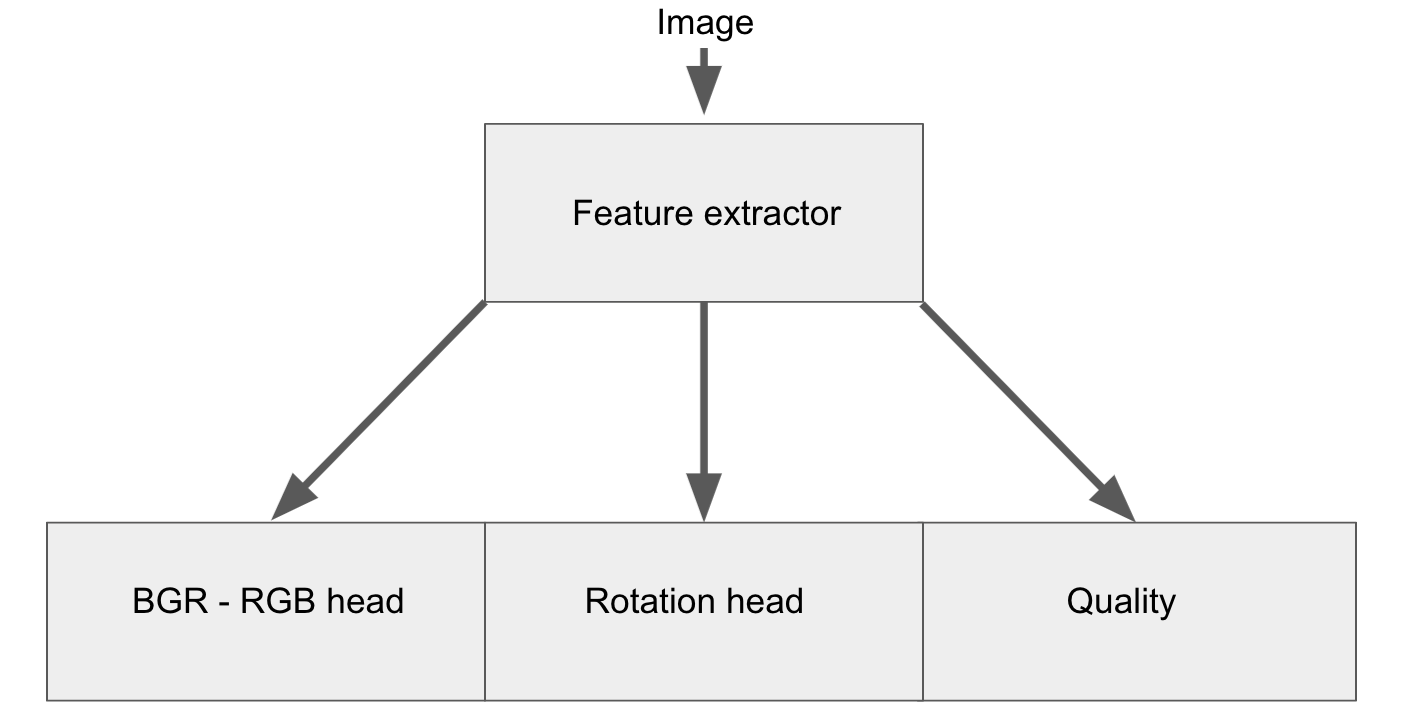

## Project Methodology

As an input, the model takes an image; as an output, there should be probabilities calculated for the next classes:

### Output - *quality*: 

**classes**: 

1. Blur - *image is blurred*

2. Torch -  *image is overexposed*

3. Sharp - *image is sharp and clean*

### Output - *rotation*:

**classes**: 

1. No rotation 0 degrees.

2. Сlockwise rotation for 90 degrees.

3. Counterclockwise rotation for 90 degrees.

4. Flipped image for 180 degrees.


### Output  RGB-BGR:

**classes**:

1. RGB

2. BGR

## Tips to mention

1. Write your own solution, do not use prettrained ones.
2. Use some of the Python libraries which you are most comfortable with - Pytorch, FastAI, Keras, Tensorflow.


## 1 Data load

In [ ]:
# set up kaggle json in colab and download the dataset
# make sure you downloaded kaggle.json locally from kaggle profile https://www.kaggle.com/YOURDISPLAYNAME/account

! pip install -q kaggle

import os
from google.colab import files

if not os.path.exists("/root/.kaggle/kaggle.json"):
  files.upload()
  ! mkdir -p ~/.kaggle
  ! mv kaggle.json ~/.kaggle/ 
  ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# example downloading dataset
!kaggle datasets download -d kwentar/blur-dataset
!unzip -qq blur-dataset.zip -d ./

In [ ]:
# imports

import cv2
import os
import numpy as np
import random

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, Input, Multiply, Activation
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau

Creating Dataset from the sharp images I got from the above link provided in the notebook.
Link to the sharp images:
[](https://)https://drive.google.com/drive/folders/1KnnG9dmSeBORX_oJKYj4Ow53XxbNiZzb?usp=sharing

In [ ]:
# overexposing our image

def adjust_gamma(image, gamma=1):
    # build a lookup table mapping the pixel values [0, 255] to their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i/255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype('uint8')

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)


# creating directories to save blurred and overexposed images

parent_dir = '/content/drive/MyDrive/Zummit-Image_Classification/Dataset/'

directory1 = 'blurred'
path_blur = os.path.join(parent_dir, directory1)
os.mkdir(path_blur)

directory2 = 'overexposed'
path_overexposed = os.path.join(parent_dir, directory2)
os.mkdir(path_overexposed)

Creating Overexposed and Blurred images from our sharp images and saving them

In [ ]:
import glob

path = "/content/drive/MyDrive/Zummit-Image_Classification/Dataset/sharp/*"
i = 1
for file in glob.glob(path):
    #print(file)
    image_read = cv2.imread(file, 1)

    # conversion numpy array into rgb image to show
    img = cv2.cvtColor(image_read, cv2.COLOR_BGR2RGB)

    # blurring and overexposing intensity
    gamma_choice = random.randint(1,6)
    blur_choice = random.choice([8,10,12,14,16])

    gamma_img = adjust_gamma(img, gamma_choice)

    # blurring images
    avg_blur = cv2.blur(img, (blur_choice, blur_choice))

    cv2.imwrite(os.path.join(path_blur,f'{i}.jpg'), avg_blur)
    cv2.imwrite(os.path.join(path_overexposed, f'{i}.jpg'), gamma_img)

    i+=1    

In [ ]:
# run this only when you have to rename images in the sub-folders

dataset_dir = '/content/drive/MyDrive/Zummit-Image_Classification/Dataset/'

for folder in os.listdir(dataset_dir):
    print(folder)
    for i, filename in enumerate(os.listdir(dataset_dir+folder)):
        #print(filename)
        os.rename(dataset_dir+folder+'/'+filename, dataset_dir+folder+'/'+folder+'_'+str(i)+'.jpg')

sharp
blurred
overexposed


In [ ]:
# Data Preparation

categories = ['blurred', 'overexposed','sharp']
training = []
IMG_SIZE = 200

def create_training_data():
    for category in categories:
        path = dataset_dir+category
        print(path)
        class_num = categories.index(category)

        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training.append([img_array, class_num])

create_training_data()


/content/drive/MyDrive/Zummit-Image_Classification/Dataset/blurred
/content/drive/MyDrive/Zummit-Image_Classification/Dataset/overexposed
/content/drive/MyDrive/Zummit-Image_Classification/Dataset/sharp


In [ ]:
# Data Preprocessing

# shuffling the dataset
random.shuffle(training)

# assigning labels and features

X = []
y = []
for features, label in training:
    X.append(features)
    y.append(label)

# resizing features in accordance with CNN
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# Normalising X and converting labels to categorical features
X = X.astype('float32')
X /= 255

y = np_utils.to_categorical(y,3)

# splitting X and y for use in CNN
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

## 2 Model

- Contruct and train the model (CNN, Transformers, SE blocks).
- Evaluate the model by any available quality metrics and confusion matrix.
- Visualize the model.
- Test the model on a test data.

### 2.3 Model - SE blocks

In [ ]:
# data augmentation

datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.1
)

datagen.fit(X_train)

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
def SE_block(inputs, ratio=8):
     b, h, w, c = inputs.shape

     # squeeze 
     x = GlobalAveragePooling2D()(inputs)
     x = Reshape((1, 1, c))(x)
     # extraction
     x = Dense(c//ratio, activation='relu', kernel_initializer='glorot_uniform', use_bias=False)(x)
     x = Dense(c, activation='sigmoid', kernel_initializer='glorot_uniform', use_bias=False)(x)

     # scaling
     x = Multiply()([inputs, x]) # x*inputs

     return x

# its returns tensor with original input shape

inputs = Input(shape=(128, 128, 32))
print(SE_block(inputs).shape)

def create_model():

    input_tensor = Input(shape=[IMG_SIZE, IMG_SIZE, 3])
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same',
               activation='relu')(input_tensor)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = SE_block(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same',activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = SE_block(x)

    # fully connected
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    output_tensor = Dense(3, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=output_tensor)

    # compiling our model
    model.compile(optimizer='adam', loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    model.summary()
    
    return model

# fittin the model

model = create_model()
epochs = 30
batch_size = 32

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                              epochs=epochs, validation_data=(X_test, y_test),
                              steps_per_epoch=X_train.shape[0]//batch_size,
                              callbacks=[learning_rate_reduction])

(None, 128, 128, 32)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 200, 200, 32  896         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 100, 100, 32  0          ['conv2d_6[0][0]']               
                                )                                      

<ipython-input-28-77ae989e3cc8>:57: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),


Epoch 1/30
26/26 [==============================] - 12s 345ms/step - loss: 1.3145 - accuracy: 0.4134 - val_loss: 0.9576 - val_accuracy: 0.6714 - lr: 0.0010
Epoch 2/30
26/26 [==============================] - 8s 312ms/step - loss: 0.7949 - accuracy: 0.6733 - val_loss: 0.7973 - val_accuracy: 0.6476 - lr: 0.0010
Epoch 3/30
26/26 [==============================] - 7s 259ms/step - loss: 0.7418 - accuracy: 0.7054 - val_loss: 0.7443 - val_accuracy: 0.7286 - lr: 0.0010
Epoch 4/30
26/26 [==============================] - 9s 332ms/step - loss: 0.7302 - accuracy: 0.7067 - val_loss: 0.7569 - val_accuracy: 0.7238 - lr: 0.0010
Epoch 5/30
26/26 [==============================] - 8s 288ms/step - loss: 0.6824 - accuracy: 0.7475 - val_loss: 0.8474 - val_accuracy: 0.6524 - lr: 0.0010
Epoch 6/30
26/26 [==============================] - 7s 269ms/step - loss: 0.6958 - accuracy: 0.7092 - val_loss: 0.6281 - val_accuracy: 0.8095 - lr: 0.0010
Epoch 7/30
26/26 [==============================] - 9s 331ms/step - l

7/7 [==============================] - 0s 17ms/step


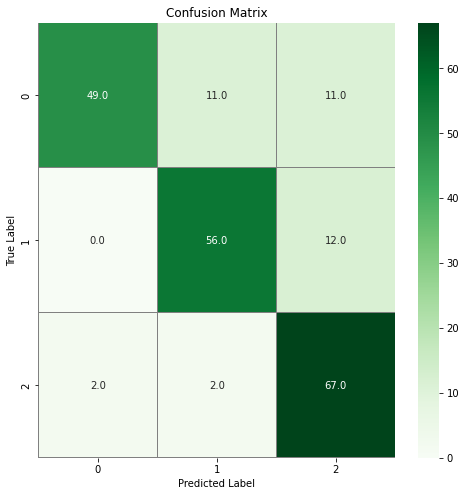

In [ ]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

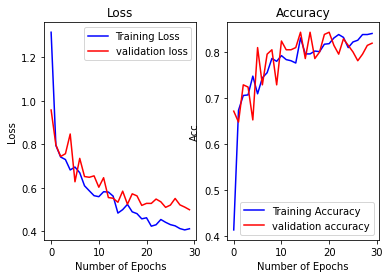

In [ ]:
# Plot the loss and accuracy curves for training and validation

plt.subplot(1,2,1) 
plt.plot(history.history['loss'], color='b', label='Training Loss')
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2) 
plt.plot(history.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='r', label="validation accuracy")
plt.title("Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Acc")
plt.legend()

plt.show()

In [1]:
###################################################

In [2]:
###################################################

In [3]:
! pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhinavyadav27","key":"a40a65e42ed5139b5e7e3d6e4e32416b"}'}

In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                        title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
themrityunjaypathak/covid-cases-and-deaths-worldwide       Covid Cases and Deaths WorldWide              8KB  2023-02-01 12:22:51           8326        267  1.0              
datascientistanna/customers-dataset                        Shop Customer Data                           23KB  2023-02-07 18:42:21           6702        153  1.0              
amaanansari09/top-100-songs                                Top 100 songs                                 6KB  2023-02-16 18:55:35           1960         70  1.0              
justin2028/unemployment-in-america-per-us-state            Unempl

In [7]:
# Download the dataset
!kaggle datasets download -d kwentar/blur-dataset
!unzip -qq blur-dataset.zip -d ./

100% 1.49G/1.49G [00:52<00:00, 31.2MB/s]
100% 1.49G/1.49G [00:52<00:00, 30.4MB/s]


In [11]:
# imports

import cv2
import imutils
import os
import numpy as np
import random

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, Input, Multiply, Activation
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau

In [85]:
# Data Preparation

dataset_dir = 'C:/Users/himan/ML/PycharmProjects/Deep Learning/Yulia_classification/data/'
categories = ['defocused_blurred', 'motion_blurred','sharp']
training = []
IMG_SIZE = 200

def create_training_data():
    for category in categories:
        path = dataset_dir+category
        print(path)
        class_num = categories.index(category)

        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training.append([img_array, class_num])

create_training_data()


C:/Users/himan/ML/PycharmProjects/Deep Learning/Yulia_classification/data/defocused_blurred


KeyboardInterrupt: 

In [3]:
# Data Preprocessing

# shuffling the dataset
random.shuffle(training)

# assigning labels and features

X = []
y = []
for features, label in training:
    X.append(features)
    y.append(label)

# resizing features in accordance with CNN
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# Normalising X and converting labels to categorical features
X = X.astype('float32')
X /= 255

y = np_utils.to_categorical(y,3)

# splitting X and y for use in CNN
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [4]:
# data augmentation

datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.1
)

datagen.fit(X_train)

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [51]:
def SE_block(inputs, ratio=8):
     b, h, w, c = inputs.shape

     # squeeze 
     x = GlobalAveragePooling2D()(inputs)
        x = Reshape((1, 1, c))(x)
     # extraction
     x = Dense(c//ratio, activation='relu', kernel_initializer='glorot_uniform', use_bias=False)(x)
        x = Dense(c, activation='sigmoid', kernel_initializer='glorot_uniform', use_bias=False)(x)

     # scaling
     x = Multiply()([inputs, x]) # x*inputs
        return x

# its returns tensor with original input shape

inputs = Input(shape=(128, 128, 32))
print(SE_block(inputs).shape)

def create_model():

    input_tensor = Input(shape=[IMG_SIZE, IMG_SIZE, 3])
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same',
               activation='relu')(input_tensor)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = SE_block(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same',activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = SE_block(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same',activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # fully connected
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    output_tensor = Dense(4, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=output_tensor)

    # compiling our model
    model.compile(optimizer='adam', loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    model.summary()
    
    return model

# fittin the model

model = create_model()
epochs = 30
batch_size = 32

history = model.fit_generator(datagen.flow(X_train_rotate, y_train_rotate, batch_size=batch_size),
                              epochs=epochs, validation_data=(X_test_rotate, y_test_rotate),
                              steps_per_epoch=X_train_rotate.shape[0]//batch_size,
                              callbacks=[learning_rate_reduction])

(None, 128, 128, 32)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 150, 150, 32  896         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 75, 75, 32)  0           ['conv2d_5[0][0]']               
                                                                       

C:\Users\himan\AppData\Local\Temp\ipykernel_17416\3402325964.py:61: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train_rotate, y_train_rotate, batch_size=batch_size),


Epoch 1/30
105/105 [==============================] - 101s 929ms/step - loss: 1.3873 - accuracy: 0.2443 - val_loss: 1.3863 - val_accuracy: 0.2488 - lr: 0.0010
Epoch 2/30
105/105 [==============================] - 95s 904ms/step - loss: 1.3870 - accuracy: 0.2449 - val_loss: 1.3863 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 3/30
105/105 [==============================] - 97s 921ms/step - loss: 1.3874 - accuracy: 0.2446 - val_loss: 1.3863 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 4/30
105/105 [==============================] - 97s 924ms/step - loss: 1.3864 - accuracy: 0.2491 - val_loss: 1.3871 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 5/30
105/105 [==============================] - 95s 904ms/step - loss: 1.3864 - accuracy: 0.2592 - val_loss: 1.3859 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 6/30
105/105 [==============================] - 94s 896ms/step - loss: 1.3794 - accuracy: 0.2786 - val_loss: 1.3860 - val_accuracy: 0.2512 - lr: 0.0010
Epoch 7/30
105/105 [==============================]

***

***

***

In [110]:
ROOT_PATH = 'C:/Users/himan/ML/PycharmProjects/Deep Learning/Yulia_classification/data/'
IMG_SIZE = 224

In [126]:
# Data Preparation

dataset_dir = 'C:/Users/himan/ML/PycharmProjects/Deep Learning/Yulia_classification/data/'
categories = ['defocused_blurred', 'motion_blurred','sharp']
training_bgr = []
training_rgb = []
IMG_SIZE = 150

def create_training_data():
    for i in range(0,2,1):
        print(i)
        for category in categories:
            path = dataset_dir+category
            print(path)
            class_num = categories.index(category)

            for img in os.listdir(path):
                if i == 0:
                    img_array = cv2.imread(os.path.join(path, img))
                    img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                    training_bgr.append([img_array, class_num])
                if i==1:
                    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                    img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                    training_rgb.append([img_array, class_num])
                    
        i+=1
                    
create_training_data()

0
C:/Users/himan/ML/PycharmProjects/Deep Learning/Yulia_classification/data/defocused_blurred
C:/Users/himan/ML/PycharmProjects/Deep Learning/Yulia_classification/data/motion_blurred
C:/Users/himan/ML/PycharmProjects/Deep Learning/Yulia_classification/data/sharp
1
C:/Users/himan/ML/PycharmProjects/Deep Learning/Yulia_classification/data/defocused_blurred
C:/Users/himan/ML/PycharmProjects/Deep Learning/Yulia_classification/data/motion_blurred
C:/Users/himan/ML/PycharmProjects/Deep Learning/Yulia_classification/data/sharp


In [137]:
# Data Preprocessing

def preprocessing(training, n):
    # shuffling the dataset
    random.shuffle(training)

    # assigning labels and features

    X = []
    y = []
    for features, label in training:
        X.append(features)
        y.append(label)

    # resizing features in accordance with CNN
    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

    # Normalising X and converting labels to categorical features
    X = X.astype('float32')
    X /= 255

    y = np_utils.to_categorical(y,n)

    # splitting X and y for use in CNN
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
    
    return X_train, X_test, y_train, y_test

In [138]:
# data augmentation

def augment(data):
    datagen = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1
    )

    datagen.fit(data)

### Rotation()

In [153]:
angles = [0, 270, 90, 180] # (0 degree, 90 degree clockwise, 90 degree anticlockwise, 180 degree or flipped image)

def rotate(image, angle):
    image = imutils.rotate(image, angle=angle) # this rotates image in anti-clockwise direction
    return image

training_rotate = []

for i in range(len(training_rgb)):
    for angle in angles:
        class_num = angles.index(angle)
        training_rgb[i][0] = rotate(training_rgb[i][0], angle)
        training_rotate.append([training_rgb[i][0], class_num]) 

for i in range(len(training_bgr)):
    for angle in angles:
        class_num = angles.index(angle)
        training_bgr[i][0] = rotate(training_bgr[i][0], angle)
        training_rotate.append([training_bgr[i][0], class_num])  

X_train_rotate, X_test_rotate, y_train_rotate, y_test_rotate = preprocessing(training_rotate, len(angles))
#augment(X_train_rotate)

In [147]:
len(X_train_rotate)

6720

In [150]:
X_train_rotate[0].shape

(150, 150, 3)

In [152]:
#augment(X_train_rotate)
len(X_train_rotate)

6720

In [115]:
len(training_rotate)

8400

### Quality  (1050 images - 3 classes)

In [154]:
training_quality = []

for i in range(len(training_rgb)):
    for angle in angles:
        training_rgb[i][0] = rotate(training_rgb[i][0], angle)
        training_quality.append([training_rgb[i][0], training[i][1]]) 
        
for i in range(len(training_bgr)):
    for angle in angles:
        training_bgr[i][0] = rotate(training_bgr[i][0], angle)
        training_quality.append([training_bgr[i][0], training[i][1]])  
         

X_train_quality, X_test_quality, y_train_quality, y_test_quality = preprocessing(training_quality, len(categories))
#X_train_quality = augment(X_train_quality)

In [117]:
len(training_quality)

8400

### BGR/RGB(2100 images - 2 classes)

In [155]:
mode = ['RGB', 'BGR']
training_mode = []

for i in range(len(training_rgb)):
    for angle in angles:
        training_rgb[i][0] = rotate(training_rgb[i][0], angle)
        training_mode.append([training_rgb[i][0], mode.index('RGB')])
        
for i in range(len(training_bgr)):
    for angle in angles:
        training_bgr[i][0] = rotate(training_bgr[i][0], angle)
        training_mode.append([training_bgr[i][0], mode.index('BGR')])  

X_train_mode, X_test_mode, y_train_mode, y_test_mode = preprocessing(training_mode, len(mode))
#X_train_mode = augment(X_train_mode)

In [122]:
len(training_mode)

8400

### Modelling

In [123]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
def SE_block(inputs, ratio=8):
    b, h, w, c = inputs.shape
    # squeeze 
    x = GlobalAveragePooling2D()(inputs)
    x = Reshape((1, 1, c))(x)
    # extraction
    x = Dense(c//ratio, activation='relu', kernel_initializer='glorot_uniform', use_bias=False)(x)
    x = Dense(c, activation='sigmoid', kernel_initializer='glorot_uniform', use_bias=False)(x)

    # scaling
    x = Multiply()([inputs, x]) # x*inputs

    return x

# its returns tensor with original input shape

inputs = Input(shape=(128, 128, 32))
print(SE_block(inputs).shape)

def create_model(name):

    input_tensor = Input(shape=[IMG_SIZE, IMG_SIZE, 3], name=name)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(input_tensor)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = SE_block(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same',activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = SE_block(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same',activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # fully connected
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    output_tensor = Dense(9, activation='relu')(x)
    model = Model(inputs=[input_tensor], outputs=[output_tensor])
    
    return model

# fittin the model

from keras.models import Model
from keras.layers import concatenate

model_quality = get_model_func('class1')
model_rotate = get_model_func('class2')
model_mode = get_model_func('class3')

# segregating out ouput layers for three different classes
mergedOutput = concatenate([model_quality.output, model_rotate.output, model_mode.output])
out_quality = Dense(3, activation='softmax', name='quality')(mergedOutput)
out_rotate = Dense(4, activation='softmax', name='rotate')(mergedOutput)
out_mode = Dense(2, activation='softmax', name='mode')(mergedOutput)

merged_model = Model(inputs=[model_quality.input, model_rotate.input, model_mode.input],
                     outputs=[out_quality, out_rotate, out_mode])

merged_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics="categorical_accuracy") 

history = merged_model.fit(x={'input1': X_train_quality, 'input2': X_train_rotate, 'input3': X_train_mode},
                 y={'quality': y_train_quality, 'rotate': y_train_rotate, 'mode': y_train_mode},
                 batch_size=64, epochs=40)

In [ ]:
from keras import Input

def get_model_func(input_name):
    input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name=input_name)
    model = Conv2D(16, (3, 3), padding='same', activation='relu')(input)
    model = Conv2D(32, (3, 3), activation='relu', padding='same')(model)
    model = Conv2D(32, (3, 3), activation='relu', padding='same')(model)
    model = MaxPooling2D(pool_size=(2, 2))(model)
    model = Dropout(0.25)(model)
    model = Conv2D(64, (3, 3), padding='same', activation='relu')(model)
    model = Conv2D(64, (3, 3), activation='relu', padding='same')(model)
    model = Conv2D(64, (3, 3), activation='relu', padding='same')(model)
    model = MaxPooling2D(pool_size=(2, 2))(model)
    model = Dropout(0.25)(model)
    model = Flatten()(model)
    out = Dense(256, activation='relu')(model)
    return Model(inputs=[input], outputs=[out])

from keras.models import Model
from keras.layers import concatenate

model_quality = get_model_func('input1')
model_rotate = get_model_func('input2')
model_mode = get_model_func('input3')

mergedOutput = concatenate([model_quality.output, model_rotate.output, model_mode.output])
out_quality = Dense(3, activation='softmax', name='quality')(mergedOutput)
out_rotate = Dense(4, activation='softmax', name='rotate')(mergedOutput)
out_mode = Dense(2, activation='softmax', name='mode')(mergedOutput)

merged_model = Model(inputs=[model_quality.input, model_rotate.input, model_mode.input],
                     outputs=[out_quality, out_rotate, out_mode])

merged_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics="categorical_accuracy") 

history = merged_model.fit(x={'input1': X_train_quality, 'input2': X_train_rotate, 'input3': X_train_mode},
                 y={'quality': y_train_quality, 'rotate': y_train_rotate, 'mode': y_train_mode},
                 batch_size=100, epochs=40)

In [ ]:
# confusion matrix


# Predict the values from the validation dataset
Y_pred = model.predict(X_test_rotate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test_rotate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
    


In [ ]:
# Plot the loss and accuracy curves for training and validation

def plot_history():
    plt.subplot(1,2,1) 
    plt.plot(history.history['loss'], color='b', label='Training Loss')
    plt.plot(history.history['val_loss'], color='r', label="validation loss")
    plt.title("Loss")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1,2,2) 
    plt.plot(history.history['accuracy'], color='b', label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], color='r', label="validation accuracy")
    plt.title("Accuracy")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Acc")
    plt.legend()

    plt.show()

In [156]:
from keras import Input

def get_model_func(input_name):
    input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name=input_name)
    model = Conv2D(16, (3, 3), padding='same', activation='relu')(input)
    model = Conv2D(32, (3, 3), activation='relu', padding='same')(model)
    model = Conv2D(32, (3, 3), activation='relu', padding='same')(model)
    model = MaxPooling2D(pool_size=(2, 2))(model)
    model = Dropout(0.25)(model)
    model = Conv2D(64, (3, 3), padding='same', activation='relu')(model)
    model = Conv2D(64, (3, 3), activation='relu', padding='same')(model)
    model = Conv2D(64, (3, 3), activation='relu', padding='same')(model)
    model = MaxPooling2D(pool_size=(2, 2))(model)
    model = Dropout(0.25)(model)
    model = Flatten()(model)
    out = Dense(256, activation='relu')(model)
    return Model(inputs=[input], outputs=[out])

from keras.models import Model
from keras.layers import concatenate

model_quality = get_model_func('input1')
model_rotate = get_model_func('input2')
model_mode = get_model_func('input3')

mergedOutput = concatenate([model_quality.output, model_rotate.output, model_mode.output])
out_quality = Dense(3, activation='softmax', name='quality')(mergedOutput)
out_rotate = Dense(4, activation='softmax', name='rotate')(mergedOutput)
out_mode = Dense(2, activation='softmax', name='mode')(mergedOutput)

merged_model = Model(inputs=[model_quality.input, model_rotate.input, model_mode.input],
                     outputs=[out_quality, out_rotate, out_mode])

merged_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics="categorical_accuracy") 

history = merged_model.fit(x={'input1': X_train_quality, 'input2': X_train_rotate, 'input3': X_train_mode},
                 y={'quality': y_train_quality, 'rotate': y_train_rotate, 'mode': y_train_mode},
                 batch_size=100, epochs=40)

Epoch 1/40
68/68 [==============================] - 2429s 35s/step - loss: 2.5672 - quality_loss: 1.1552 - rotate_loss: 1.2140 - mode_loss: 0.1980 - quality_categorical_accuracy: 0.3323 - rotate_categorical_accuracy: 0.4940 - mode_categorical_accuracy: 0.9240
Epoch 2/40
42/68 [=================>............] - ETA: 15:54 - loss: 1.9035 - quality_loss: 1.0629 - rotate_loss: 0.8294 - mode_loss: 0.0112 - quality_categorical_accuracy: 0.4131 - rotate_categorical_accuracy: 0.5864 - mode_categorical_accuracy: 0.9983

KeyboardInterrupt: 

## Deadline - February 21st EOD
















































